In [1]:
%matplotlib inline
import mindspore as m

m.set_context(mode=m.GRAPH_MODE, device_target="GPU")


In [2]:
train_data_path = r"data/MPI-Sintel-complete/training"
val_data_path = r"data/MPI-Sintel-complete/training"

batch_size = 4
lr = 0.00001
num_parallel_workers = 2
lr_milestones = [5558 * 4, 5558 * 6, 5558 * 8]
lr_gamma = 0.5
max_epoch = 50
loss_scale = 1


In [3]:
import mindspore.dataset.vision as V

from src.dataset_utils import RandomGamma

augmentation_list = [
    V.ToPIL(),
    V.RandomColorAdjust(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    V.ToTensor(),
    RandomGamma(min_gamma=0.7, max_gamma=1.5, clip_image=True),
]


In [4]:
str1 = 'data/MPI-Sintel-complete/training/final/alley_1'
str2 = 'data/MPI-Sintel-complete/training/flow/alley_1/frame_0001.flo'
print(str1 in str2)

False


In [5]:
from src.dataset import getFlyingChairsTrainData, getSintelValData

dl_train, len_dl_train, dataset = getSintelValData(
    root=train_data_path,
    split="train",
    augmentations=augmentation_list,
    batch_size=batch_size,
    num_parallel_workers=num_parallel_workers,
)
dl_val, len_dl_val, val_dataset = getSintelValData(
    root=val_data_path,
    split="val",
    augmentations=augmentation_list,
    batch_size=batch_size,
    num_parallel_workers=num_parallel_workers,
)

print(f"The dataset size of dl_train: {dl_train.get_dataset_size()}")
print(f"The dataset size of dl_val: {dl_val.get_dataset_size()}")

dict_datasets = next(dl_train.create_dict_iterator())
print(dict_datasets.keys())
print(dict_datasets["im1"].shape)
print(dict_datasets["im2"].shape)
print(dict_datasets["flo"].shape)
print(type(dict_datasets["flo"]))


SintelDataset: 133 val flows, 908 train flows
SintelDataset: 133 val flows, 908 train flows
The dataset size of dl_train: 227
The dataset size of dl_val: 33


[WARNING] ME(172008:140505466127872,_GeneratorWorkerMp-7):2022-09-23-05:23:09.166.271 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 6291456


dict_keys(['im1', 'im2', 'flo'])
(4, 3, 384, 512)
(4, 3, 384, 512)
(4, 2, 384, 512)
<class 'mindspore.common.tensor.Tensor'>


Text(0.5, 1.0, 'Optical Flow')

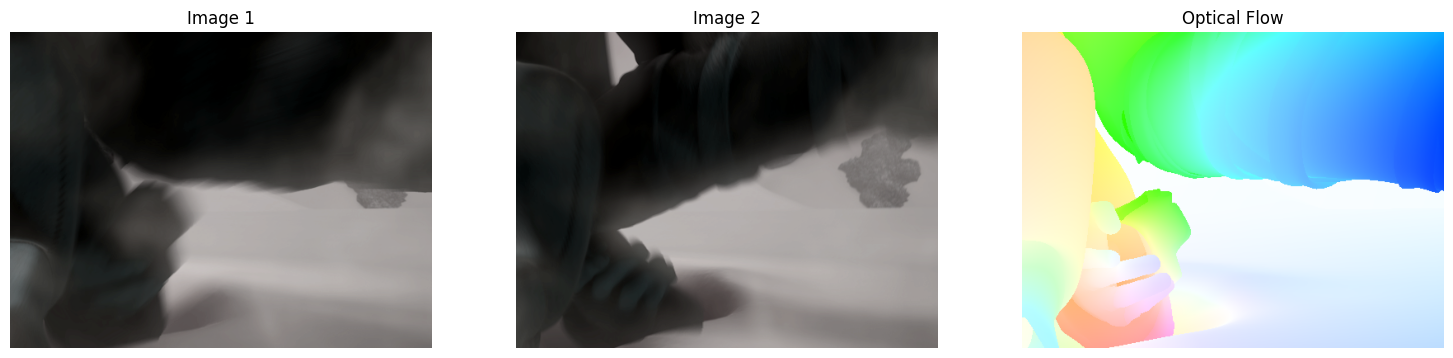

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import flow_vis

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.subplot(131)
ax.imshow(np.transpose(dict_datasets["im1"][0].asnumpy(), (1, 2, 0)))
ax.set_title("Image 1")
ax.set_axis_off()
ax = plt.subplot(132)
ax.imshow(np.transpose(dict_datasets["im2"][0].asnumpy(), (1, 2, 0)))
ax.set_title("Image 2")
ax.set_axis_off()
ax = plt.subplot(133)
ax.imshow(
    flow_vis.flow_to_color(np.transpose(dict_datasets["flo"][0].asnumpy(), (1, 2, 0)))
)
ax.set_axis_off()
ax.set_title("Optical Flow")


In [7]:
from src.pwc_net import PWCNet
from src.loss import PyramidEPE, MultiStepLR

from mindspore.nn import Adam

net = PWCNet()
criterion = PyramidEPE()

optimizer = Adam(
    params=net.trainable_params(),
    learning_rate=lr,
    loss_scale=loss_scale
)


81
211
179
147
115


In [8]:
import mindspore.nn as nn
from mindspore.train.callback import LossMonitor, TimeMonitor
from mindspore import Model

class BuildTrainNetwork(nn.Cell):
    '''BuildTrainNetwork'''
    def __init__(self, network, criterion):
        super(BuildTrainNetwork, self).__init__(auto_prefix=False)
        self.network = network
        self.criterion = criterion

    def construct(self, x1_raw, x2_raw, target):
        result = self.network(x1_raw, x2_raw)
        loss = self.criterion(result, target)
        return loss

net_with_loss = BuildTrainNetwork(net, criterion)
# train_one_step = nn.TrainOneStepCell(net_with_loss, optimizer)
model = Model(network=net_with_loss, optimizer=optimizer, eval_network=net_with_loss, metrics={'loss'})




In [9]:
from mindspore.train.callback import Callback
from src.callback import ValLossMonitor

ckpt_config = m.CheckpointConfig(save_checkpoint_steps=dl_train.get_dataset_size(), keep_checkpoint_max=100)
ckpt_callback = m.ModelCheckpoint(prefix='pwc_net', directory='./pwc_net', config=ckpt_config)

loss_cb = ValLossMonitor(model, dl_val, max_epoch, ckpt_directory="./ckpt")

In [10]:
model.train(epoch=max_epoch, train_dataset=dl_train, callbacks=[TimeMonitor(dl_train.get_dataset_size()), loss_cb], dataset_sink_mode=True)

[WARNING] ME(171937:140505466127872,MainProcess):2022-09-23-05:23:12.823.282 [mindspore/train/model.py:1077] For ValLossMonitor callback, {'epoch_end', 'end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(172906:140505466127872,_GeneratorWorkerMp-13):2022-09-23-05:23:13.217.11 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 6291456
[WARNING] ME(172957:140505466127872,_GeneratorWorkerMp-16):2022-09-23-05:23:13.478.499 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 6291456
[WARNING] ME(173015:140505466127872,_GeneratorWorkerMp-22):2022-09-23-05:23:15.184.494 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 cu

Train epoch time: 130306.529 ms, per step time: 574.038 ms


[WARNING] ME(173196:140505466127872,_GeneratorWorkerMp-25):2022-09-23-05:25:24.804.829 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(173250:140505466127872,_GeneratorWorkerMp-28):2022-09-23-05:25:27.567.014 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(173315:140505466127872,_GeneratorWorkerMp-37):2022-09-23-05:25:33.198.395 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  1 /  50], Train Loss: [18.332], loss:  16.991
Train epoch time: 36127.597 ms, per step time: 159.152 ms


[WARNING] ME(173485:140505466127872,_GeneratorWorkerMp-41):2022-09-23-05:27:27.433.081 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  2 /  50], Train Loss: [2.395], loss:  16.993
Train epoch time: 36590.348 ms, per step time: 161.191 ms


[WARNING] ME(173588:140505466127872,_GeneratorWorkerMp-43):2022-09-23-05:28:15.561.166 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  3 /  50], Train Loss: [13.688], loss:  17.000
Train epoch time: 36700.344 ms, per step time: 161.676 ms


[WARNING] ME(173692:140505466127872,_GeneratorWorkerMp-46):2022-09-23-05:29:03.811.088 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  4 /  50], Train Loss: [3.849], loss:  16.990
Train epoch time: 36668.209 ms, per step time: 161.534 ms


[WARNING] ME(173794:140505466127872,_GeneratorWorkerMp-49):2022-09-23-05:29:51.510.194 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(173795:140505466127872,_GeneratorWorkerMp-50):2022-09-23-05:29:51.511.098 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  5 /  50], Train Loss: [17.057], loss:  17.002
Train epoch time: 36698.845 ms, per step time: 161.669 ms


[WARNING] ME(173901:140505466127872,_GeneratorWorkerMp-53):2022-09-23-05:30:39.751.231 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  6 /  50], Train Loss: [2.058], loss:  16.994
Train epoch time: 36704.924 ms, per step time: 161.696 ms


[WARNING] ME(174003:140505466127872,_GeneratorWorkerMp-56):2022-09-23-05:31:28.899.98 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  7 /  50], Train Loss: [16.541], loss:  16.999
Train epoch time: 36679.230 ms, per step time: 161.583 ms


[WARNING] ME(174107:140505466127872,_GeneratorWorkerMp-59):2022-09-23-05:32:16.305.796 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  8 /  50], Train Loss: [11.753], loss:  16.995
Train epoch time: 36681.731 ms, per step time: 161.594 ms


[WARNING] ME(174211:140505466127872,_GeneratorWorkerMp-62):2022-09-23-05:33:04.448.048 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(174210:140505466127872,_GeneratorWorkerMp-61):2022-09-23-05:33:04.448.717 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [  9 /  50], Train Loss: [3.815], loss:  17.005
Train epoch time: 36670.178 ms, per step time: 161.543 ms


[WARNING] ME(174315:140505466127872,_GeneratorWorkerMp-65):2022-09-23-05:33:52.529.537 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 10 /  50], Train Loss: [26.447], loss:  17.004
Train epoch time: 36665.351 ms, per step time: 161.521 ms


[WARNING] ME(174417:140505466127872,_GeneratorWorkerMp-67):2022-09-23-05:34:40.754.199 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 11 /  50], Train Loss: [1.872], loss:  17.005
Train epoch time: 36695.925 ms, per step time: 161.656 ms


[WARNING] ME(174522:140505466127872,_GeneratorWorkerMp-70):2022-09-23-05:35:28.873.969 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 12 /  50], Train Loss: [11.027], loss:  17.010
Train epoch time: 36683.957 ms, per step time: 161.603 ms


[WARNING] ME(174625:140505466127872,_GeneratorWorkerMp-74):2022-09-23-05:36:17.121.843 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 13 /  50], Train Loss: [15.057], loss:  16.989
Train epoch time: 36708.669 ms, per step time: 161.712 ms


[WARNING] ME(174728:140505466127872,_GeneratorWorkerMp-76):2022-09-23-05:37:05.351.989 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 14 /  50], Train Loss: [34.451], loss:  16.996
Train epoch time: 36693.599 ms, per step time: 161.646 ms


[WARNING] ME(174832:140505466127872,_GeneratorWorkerMp-80):2022-09-23-05:37:53.677.796 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 15 /  50], Train Loss: [17.379], loss:  16.992
Train epoch time: 36665.969 ms, per step time: 161.524 ms


[WARNING] ME(174936:140505466127872,_GeneratorWorkerMp-82):2022-09-23-05:38:42.584.16 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 16 /  50], Train Loss: [24.812], loss:  17.004
Train epoch time: 36660.935 ms, per step time: 161.502 ms


[WARNING] ME(175039:140505466127872,_GeneratorWorkerMp-86):2022-09-23-05:39:29.881.608 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 17 /  50], Train Loss: [22.075], loss:  17.009
Train epoch time: 36715.634 ms, per step time: 161.743 ms


[WARNING] ME(175140:140505466127872,_GeneratorWorkerMp-88):2022-09-23-05:40:18.172.555 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 18 /  50], Train Loss: [17.012], loss:  17.007
Train epoch time: 36683.676 ms, per step time: 161.602 ms


[WARNING] ME(175244:140505466127872,_GeneratorWorkerMp-91):2022-09-23-05:41:05.866.117 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 19 /  50], Train Loss: [13.671], loss:  17.014
Train epoch time: 36681.083 ms, per step time: 161.591 ms


[WARNING] ME(175348:140505466127872,_GeneratorWorkerMp-94):2022-09-23-05:41:53.977.994 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(175349:140505466127872,_GeneratorWorkerMp-95):2022-09-23-05:41:53.979.395 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 20 /  50], Train Loss: [10.980], loss:  17.011
Train epoch time: 36714.120 ms, per step time: 161.736 ms


[WARNING] ME(175453:140505466127872,_GeneratorWorkerMp-97):2022-09-23-05:42:41.775.244 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 21 /  50], Train Loss: [21.443], loss:  17.009
Train epoch time: 36706.372 ms, per step time: 161.702 ms


[WARNING] ME(175556:140505466127872,_GeneratorWorkerMp-101):2022-09-23-05:43:29.456.992 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 22 /  50], Train Loss: [4.445], loss:  16.996
Train epoch time: 36759.081 ms, per step time: 161.934 ms


[WARNING] ME(175659:140505466127872,_GeneratorWorkerMp-103):2022-09-23-05:44:17.140.012 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 23 /  50], Train Loss: [5.689], loss:  17.006
Train epoch time: 36746.646 ms, per step time: 161.879 ms


[WARNING] ME(175761:140505466127872,_GeneratorWorkerMp-106):2022-09-23-05:45:04.868.438 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 24 /  50], Train Loss: [11.427], loss:  17.018
Train epoch time: 36730.539 ms, per step time: 161.809 ms


[WARNING] ME(175866:140505466127872,_GeneratorWorkerMp-110):2022-09-23-05:45:53.128.945 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(175865:140505466127872,_GeneratorWorkerMp-109):2022-09-23-05:45:53.129.753 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 25 /  50], Train Loss: [10.498], loss:  16.993
Train epoch time: 36711.519 ms, per step time: 161.725 ms


[WARNING] ME(175970:140505466127872,_GeneratorWorkerMp-112):2022-09-23-05:46:40.874.824 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 26 /  50], Train Loss: [6.472], loss:  16.995
Train epoch time: 36682.812 ms, per step time: 161.598 ms


[WARNING] ME(176073:140505466127872,_GeneratorWorkerMp-115):2022-09-23-05:47:28.621.646 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 27 /  50], Train Loss: [16.569], loss:  17.000
Train epoch time: 36729.342 ms, per step time: 161.803 ms


[WARNING] ME(176175:140505466127872,_GeneratorWorkerMp-118):2022-09-23-05:48:16.485.656 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 28 /  50], Train Loss: [17.535], loss:  16.970
Train epoch time: 36730.580 ms, per step time: 161.809 ms


[WARNING] ME(176277:140505466127872,_GeneratorWorkerMp-121):2022-09-23-05:49:04.172.758 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 29 /  50], Train Loss: [4.030], loss:  16.972
Train epoch time: 36674.954 ms, per step time: 161.564 ms


[WARNING] ME(176380:140505466127872,_GeneratorWorkerMp-124):2022-09-23-05:49:51.786.842 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 30 /  50], Train Loss: [4.597], loss:  16.970
Train epoch time: 36746.311 ms, per step time: 161.878 ms


[WARNING] ME(176486:140505466127872,_GeneratorWorkerMp-128):2022-09-23-05:50:39.499.440 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 31 /  50], Train Loss: [20.023], loss:  16.973
Train epoch time: 36731.384 ms, per step time: 161.812 ms


[WARNING] ME(176587:140505466127872,_GeneratorWorkerMp-130):2022-09-23-05:51:27.221.614 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 32 /  50], Train Loss: [32.990], loss:  16.973
Train epoch time: 36712.512 ms, per step time: 161.729 ms


[WARNING] ME(176689:140505466127872,_GeneratorWorkerMp-133):2022-09-23-05:52:14.846.828 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 33 /  50], Train Loss: [15.510], loss:  16.993
Train epoch time: 36723.047 ms, per step time: 161.776 ms


[WARNING] ME(176793:140505466127872,_GeneratorWorkerMp-136):2022-09-23-05:53:02.623.144 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 34 /  50], Train Loss: [37.087], loss:  16.987
Train epoch time: 36751.440 ms, per step time: 161.901 ms


[WARNING] ME(176895:140505466127872,_GeneratorWorkerMp-139):2022-09-23-05:53:50.260.454 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 35 /  50], Train Loss: [5.351], loss:  16.966
Train epoch time: 36713.119 ms, per step time: 161.732 ms


[WARNING] ME(176998:140505466127872,_GeneratorWorkerMp-143):2022-09-23-05:54:37.770.711 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 36 /  50], Train Loss: [9.661], loss:  16.983
Train epoch time: 36721.045 ms, per step time: 161.767 ms


[WARNING] ME(177100:140505466127872,_GeneratorWorkerMp-146):2022-09-23-05:55:25.504.669 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 37 /  50], Train Loss: [6.283], loss:  16.971
Train epoch time: 36726.953 ms, per step time: 161.793 ms


[WARNING] ME(177206:140505466127872,_GeneratorWorkerMp-149):2022-09-23-05:56:13.143.508 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 38 /  50], Train Loss: [5.291], loss:  16.958
Train epoch time: 36723.363 ms, per step time: 161.777 ms


[WARNING] ME(177307:140505466127872,_GeneratorWorkerMp-151):2022-09-23-05:57:00.841.407 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 39 /  50], Train Loss: [2.186], loss:  16.993
Train epoch time: 36712.044 ms, per step time: 161.727 ms


[WARNING] ME(177409:140505466127872,_GeneratorWorkerMp-154):2022-09-23-05:57:48.520.507 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 40 /  50], Train Loss: [5.281], loss:  16.961
Train epoch time: 36694.320 ms, per step time: 161.649 ms


[WARNING] ME(177511:140505466127872,_GeneratorWorkerMp-157):2022-09-23-05:58:36.249.952 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 41 /  50], Train Loss: [9.395], loss:  16.960
Train epoch time: 36727.995 ms, per step time: 161.797 ms


[WARNING] ME(177616:140505466127872,_GeneratorWorkerMp-161):2022-09-23-05:59:24.473.18 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 42 /  50], Train Loss: [3.399], loss:  16.991
Train epoch time: 36685.385 ms, per step time: 161.610 ms


[WARNING] ME(177717:140505466127872,_GeneratorWorkerMp-163):2022-09-23-06:00:11.805.913 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 43 /  50], Train Loss: [12.605], loss:  16.993
Train epoch time: 36692.363 ms, per step time: 161.640 ms


[WARNING] ME(177821:140505466127872,_GeneratorWorkerMp-166):2022-09-23-06:00:59.483.555 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 44 /  50], Train Loss: [8.515], loss:  16.979
Train epoch time: 36729.793 ms, per step time: 161.805 ms


[WARNING] ME(177925:140505466127872,_GeneratorWorkerMp-170):2022-09-23-06:01:47.189.579 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 45 /  50], Train Loss: [1.806], loss:  16.970
Train epoch time: 36714.844 ms, per step time: 161.739 ms


[WARNING] ME(178027:140505466127872,_GeneratorWorkerMp-172):2022-09-23-06:02:34.918.893 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(178028:140505466127872,_GeneratorWorkerMp-173):2022-09-23-06:02:34.921.852 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 46 /  50], Train Loss: [4.986], loss:  16.971
Train epoch time: 36746.753 ms, per step time: 161.880 ms


[WARNING] ME(178131:140505466127872,_GeneratorWorkerMp-175):2022-09-23-06:03:22.517.363 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(178132:140505466127872,_GeneratorWorkerMp-176):2022-09-23-06:03:22.519.558 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 47 /  50], Train Loss: [2.829], loss:  16.982
Train epoch time: 36709.208 ms, per step time: 161.715 ms


[WARNING] ME(178236:140505466127872,_GeneratorWorkerMp-179):2022-09-23-06:04:10.314.963 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136
[WARNING] ME(178235:140505466127872,_GeneratorWorkerMp-178):2022-09-23-06:04:10.318.255 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 48 /  50], Train Loss: [6.014], loss:  16.946
Train epoch time: 36719.841 ms, per step time: 161.761 ms


[WARNING] ME(178341:140505466127872,_GeneratorWorkerMp-181):2022-09-23-06:04:58.501.17 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 49 /  50], Train Loss: [12.299], loss:  16.984
Train epoch time: 36132.971 ms, per step time: 159.176 ms


[WARNING] ME(178443:140505466127872,_GeneratorWorkerMp-184):2022-09-23-06:05:45.219.123 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


--------------------
Epoch: [ 50 /  50], Train Loss: [10.446], loss:  16.966
End of validation the best loss is:  17.018, save the best ckpt file in ./ckpt/best.ckpt


In [11]:
model.eval(dl_val, dataset_sink_mode=True)

[WARNING] ME(178511:140505466127872,_GeneratorWorkerMp-187):2022-09-23-06:05:56.277.211 [mindspore/dataset/engine/queue.py:125] Using shared memory queue, but rowsize is larger than allocated memory max_rowsize 6291456 current rowsize 10715136


{'loss': 16.977238142129146}